# CLV Quickstart

---
NOTE:  This example has been adapted from: 

- Dataset: https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/cdnow_transactions.csv
- Notebook: https://github.com/pymc-labs/pymc-marketing/blob/main/docs/source/notebooks/clv/clv_quickstart.ipynb
---

Customer Lifetime Value (CLV) is the measure of a customer's contribution over time to a business. This metric is used to inform spending levels on new customer acquisition, retention, and other marketing and sales efforts, so reliable estimation is essential.

PyMC-Marketing provides tools to segment customers on their past behavior (see [RFM Segmentation](https://www.pymc-marketing.io/en/stable/api/generated/pymc_marketing.clv.utils.rfm_segments.html#pymc_marketing.clv.utils.rfm_segments)) as well as the following Buy Till You Die (BTYD) probabilistic models to predict future behavior:

* **[BG/NBD model](https://pymc-marketing.readthedocs.io/en/stable/notebooks/clv/bg_nbd.html)** for continuous time, non-contractual modeling
* **[Pareto/NBD model](https://pymc-marketing.readthedocs.io/en/stable/notebooks/clv/pareto_nbd.html)** for continuous time, non-contractual modeling with covariates
* **[Shifted BG model](https://pymc-marketing.readthedocs.io/en/stable/notebooks/clv/sBG.html)** for discrete time, contractual modeling
* **[BG/BB model](https://www.pymc-marketing.io/en/latest/api/generated/pymc_marketing.clv.models.beta_geo_beta_binom.BetaGeoBetaBinomModel.html)** for discrete time, contractual modeling
* **Exponential Gamma model** for discrete time, contractual modeling (coming soon)
* **[Gamma-Gamma model](https://pymc-marketing.readthedocs.io/en/stable/notebooks/clv/gamma_gamma.html)** for expected monetary value
* **[Modified BG/NBD model](https://pymc-marketing.readthedocs.io/en/stable/notebooks/clv/mbg_nbd.html)**, similar to the BG/NBD model, but assumes non-repeat customers are still active.

This table contains a breakdown of the four BTYD modeling domains, and examples for each:

|                | **Non-contractual** | **Contractual**                 |
|----------------|---------------------|---------------------------------|
| **Continuous** | online purchases    | ad conversion time              |
| **Discrete**   | concerts & sports events    | recurring subscriptions |

In this notebook we will demonstrate how to estimate future purchasing activity and CLV with the CDNOW dataset, a popular benchmarking dataset in CLV and BTYD research. Data is available [here](https://www.brucehardie.com/datasets/), with additional details [here](https://www.brucehardie.com/notes/026/).

In [1]:
! pip install -q pymc-marketing

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arviz.labels import MapLabeller

from pymc_marketing import clv
from pymc_marketing.prior import Prior

In [3]:
az.style.use("arviz-darkgrid")

%config InlineBackend.figure_format = "retina" # nice looking plots

## Data Requirements

For all models, the following nomenclature is used:

* `customer_id` represents a unique identifier for each customer.
* `frequency` represents the number of _repeat_ purchases that a customer has made, i.e. one less than the total number of purchases.
* `T` represents a customer's "age", i.e. the duration between a customer's first purchase and the end of the period of study. In this example notebook, the units of time are in weeks.
* `recency` represents the time period when a customer made their most recent purchase. This is equal to the duration between a customer’s first and last purchase. If a customer has made only 1 purchase, their recency is 0.
* `monetary_value` represents the average value of a given customer’s repeat purchases. Customers who have only made a single purchase have monetary values of zero.

The `rfm_summary` function can be used to preprocess raw transaction data for modeling:

### Upload data into Vast DB via VMS UI

NOTE: VMS UI load requires Vast Data 5.3+

- Navigate to the VMS
- Open Database, Schema
- Click Upload File
- Upload `clv_quickstart.csv`


In [4]:
# Update these values to match the values above

DATABASE_NAME = "csnow-db"
SCHEMA_NAME = "clv"
TABLE_NAME = "cdnow_transactions"

In [5]:
import os

VASTDB_ENDPOINT = os.getenv("VASTDB_ENDPOINT")
VASTDB_ACCESS_KEY = os.getenv("VASTDB_ACCESS_KEY")
VASTDB_SECRET_KEY = os.getenv("VASTDB_SECRET_KEY")

import pyarrow as pa
import vastdb

session = vastdb.connect(
    endpoint=VASTDB_ENDPOINT,
    access=VASTDB_ACCESS_KEY,
    secret=VASTDB_SECRET_KEY)

with session.transaction() as tx:
    bucket = tx.bucket(DATABASE_NAME)
    schema = bucket.schema(SCHEMA_NAME)
    table = schema.table(TABLE_NAME)

    result = table.select().read_all()
    # print(result)
    print(f"Number of records read: {result.num_rows}")

    raw_trans = result.to_pandas()

Number of records read: 6919


In [6]:
raw_trans.head(5)

,_id,id,date,cds_bought,spent
0,4,1,19970101,2,29.33
1,4,1,19970118,2,29.73
2,4,1,19970802,1,14.96
3,4,1,19971212,2,26.48
4,21,2,19970101,3,63.34


In [7]:
rfm_data = clv.utils.rfm_summary(
    raw_trans,
    customer_id_col="id",
    datetime_col="date",
    monetary_value_col="spent",
    datetime_format="%Y%m%d",
    time_unit="W",
)

rfm_data

,customer_id,frequency,recency,T,monetary_value
0,1,3.0,49.0,78.0,23.723333
1,2,1.0,2.0,78.0,11.770000
2,3,0.0,0.0,78.0,0.000000
3,4,0.0,0.0,78.0,0.000000
4,5,0.0,0.0,78.0,0.000000
...,...,...,...,...,...
2352,2353,2.0,53.0,66.0,19.775000
2353,2354,5.0,24.0,66.0,44.928000
2354,2355,1.0,44.0,66.0,24.600000
2355,2356,6.0,62.0,66.0,31.871667


It is important to note these definitions differ from that used in RFM segmentation, where the first purchase is included, `T` is not used, and `recency` is the number of time periods since a customer's most recent purchase.

To visualize data in RFM format, we can plot the recency and T of the customers with the `plot_customer_exposure` function. We see a large chunk (>60%) of customers haven't made another purchase in a while.

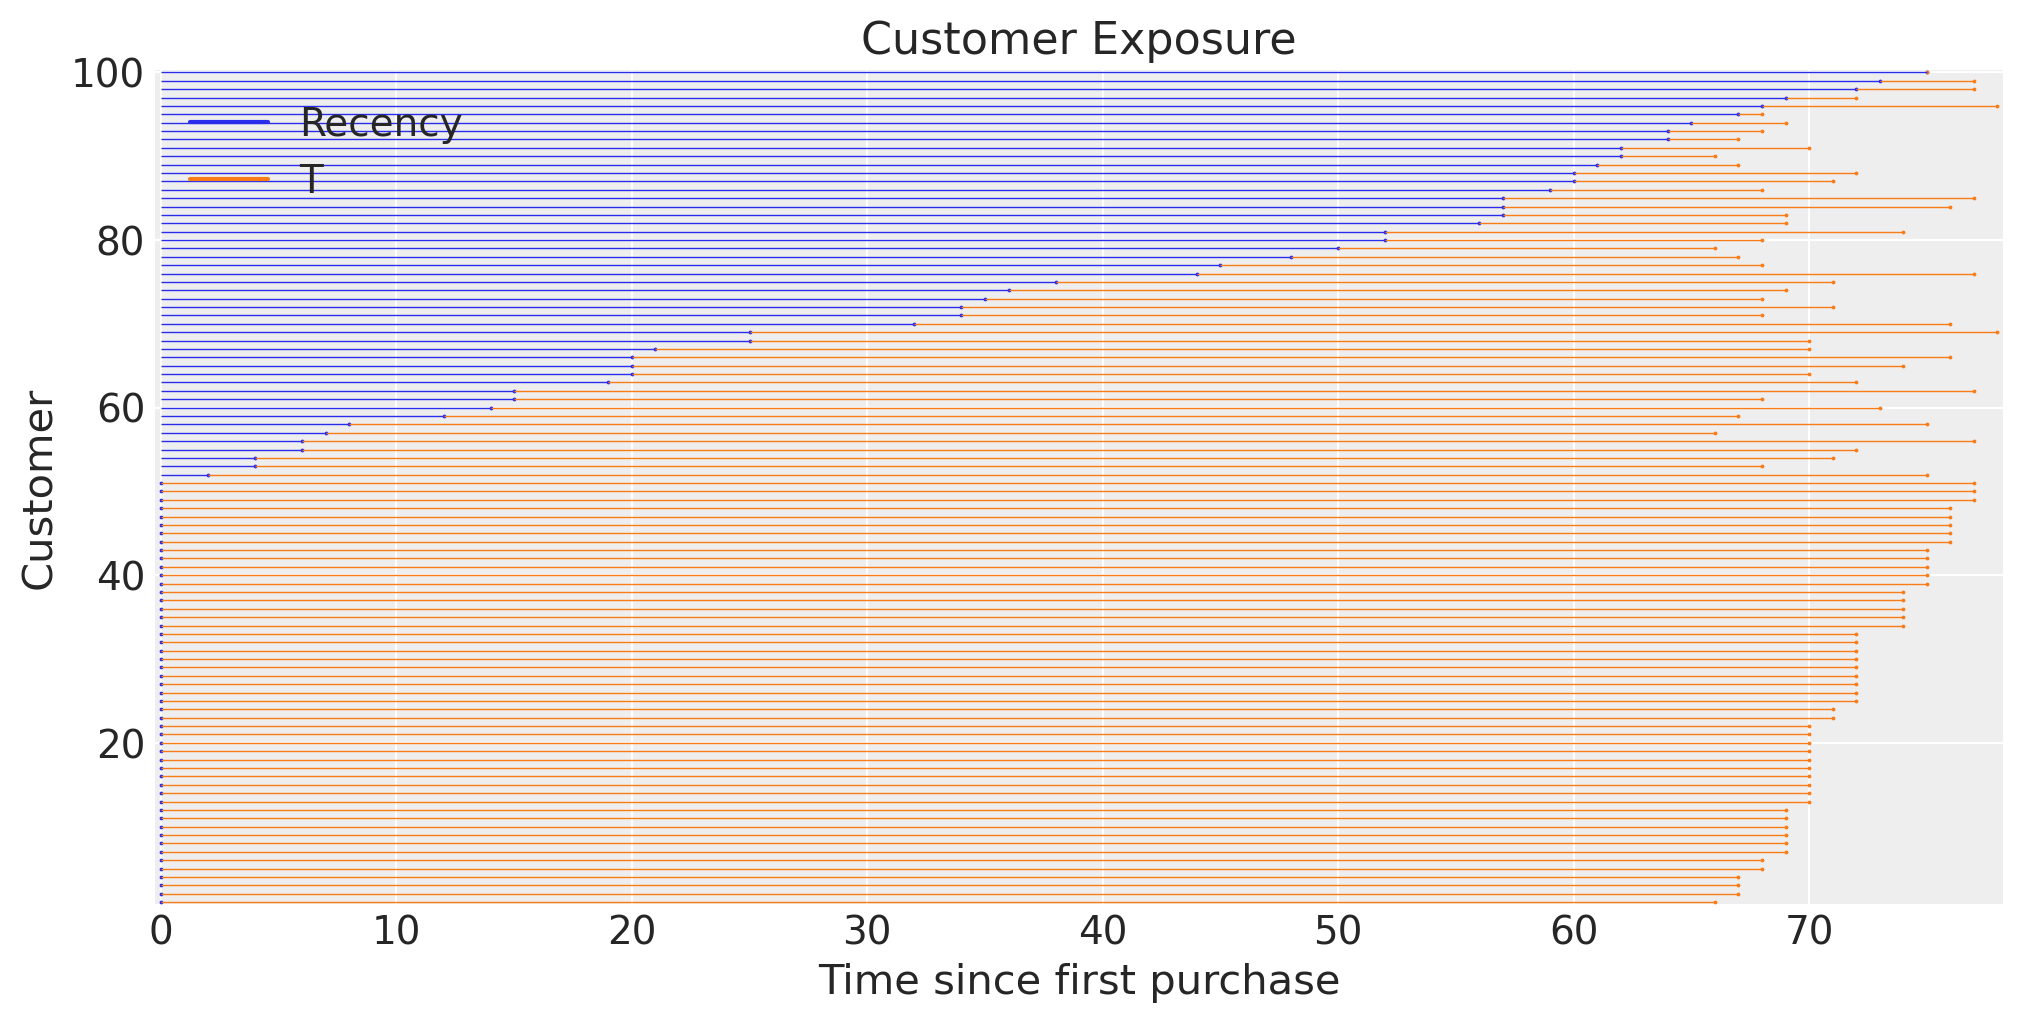

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
(
    rfm_data.sample(n=100, random_state=42)
    .sort_values(["recency", "T"])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
);

## Predicting Future Purchasing Behavior with the BG/NBD Model

This dataset is an example of continuous time, noncontractual transactions because it comprises purchases from an online music store. PyMC-Marketing provides two models for this use case:

- [Beta-Geometric/Negative Binomial Distribution (BG/NBD)](https://pymc-marketing.readthedocs.io/en/stable/notebooks/clv/bg_nbd.html)
- [Pareto/Negative Binomial Distribution (Pareto/NBD)](https://pymc-marketing.readthedocs.io/en/stable/notebooks/clv/pareto_nbd.html)

We will be using the BG/NBD model in this notebook because it converges quickly and works well for basic modeling tasks. However, if a more comprehensive analysis is desired, consider using the Pareto/NBD model instead due to its expanded functionality, including support for covariates.

Let's take a look at the underlying structure of the BG/NBD model:

In [9]:
! pip install -q graphviz

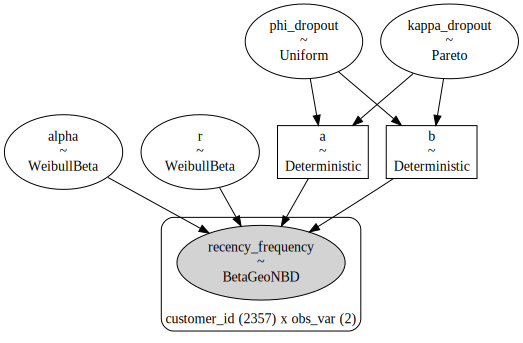

In [10]:
bgm = clv.BetaGeoModel(data=rfm_data)

bgm.build_model()
bgm.graphviz()

The default priors for the `r` and `alpha` purchase rate parameters follow a HalfFlat distribution, which is an uninformative positive distribution. The `a` and `b` dropout parameters are pooled with the hierarchical `kappa_dropout` and `phi_dropout` priors for improved performance.

More informative priors can be specified in a custom model configuration by passing a dictionary with keys for prior names, and values as distributions defined with the `Prior` class in PyMC-Marketing.

In [11]:
model_config = {
    "a": Prior("HalfNormal", sigma=10),
    "b": Prior("HalfNormal", sigma=10),
    "alpha": Prior("HalfNormal", sigma=10),
    "r": Prior("HalfNormal", sigma=10),
}

In [12]:
bgm = clv.BetaGeoModel(
    data=rfm_data,
    model_config=model_config,
)
bgm.build_model()
bgm

BG/NBD
            alpha ~ HalfNormal(0, 10)
                a ~ HalfNormal(0, 10)
                b ~ HalfNormal(0, 10)
                r ~ HalfNormal(0, 10)
recency_frequency ~ BetaGeoNBD(a, b, r, alpha, <constant>)

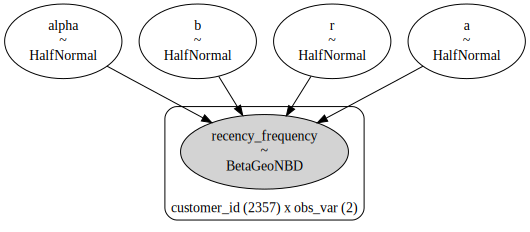

In [13]:
bgm.graphviz()

Having specified the model, we can now fit it.

In [14]:
bgm.fit()
bgm.fit_summary()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, a, b, r]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,7.108,0.500,6.151,8.027,0.012,0.009,1877.0,2035.0,1.0
a,0.686,0.154,0.417,0.973,0.004,0.003,1937.0,2457.0,1.0
b,3.252,0.964,1.740,5.099,0.022,0.024,1973.0,2332.0,1.0
r,0.276,0.012,0.254,0.298,0.000,0.000,1925.0,2078.0,1.0


We can use [ArviZ](https://python.arviz.org/en/stable/), a Python library tailored to produce visualizations for Bayesian models, to plot the posterior distribution of each parameter.

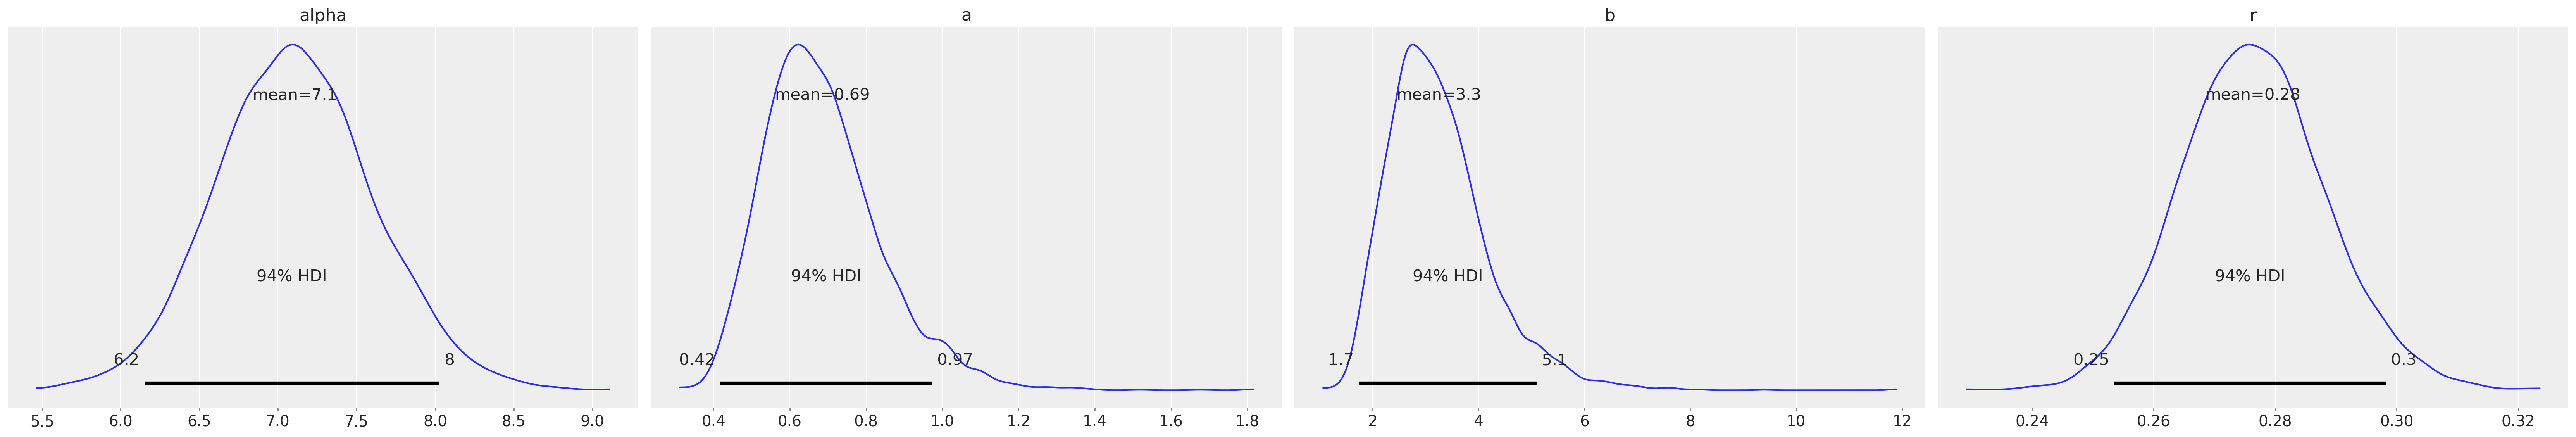

In [15]:
az.plot_posterior(bgm.fit_result);

### 1.2.1. Visualizing Predictions over Time

Let's evaluate model performance by tracking predictions against historical purchases:

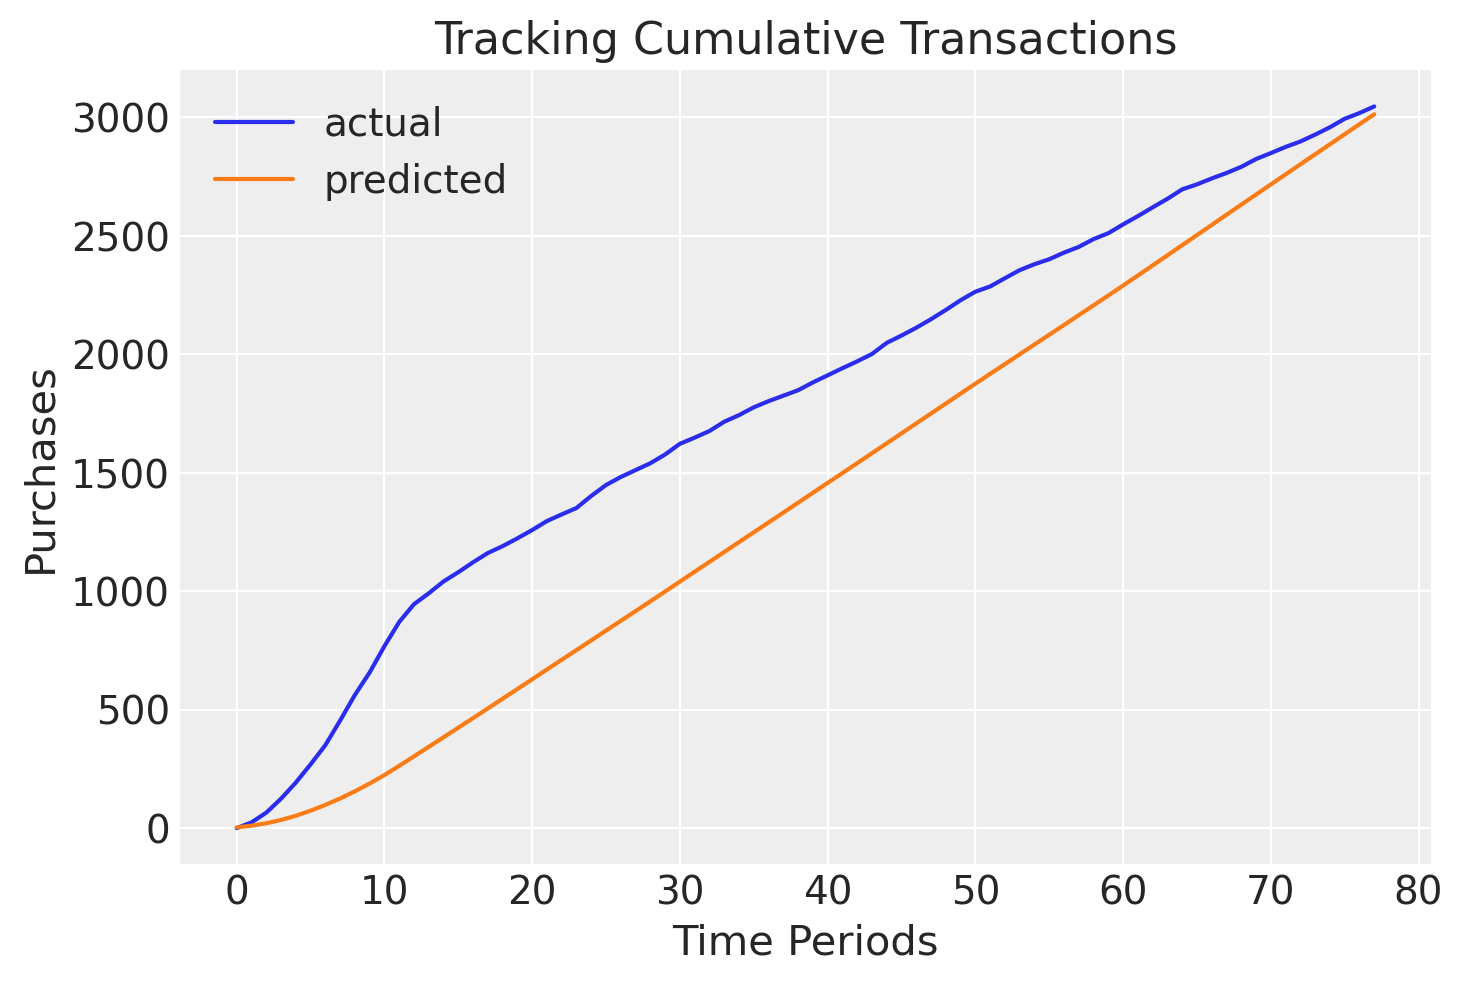

In [16]:
clv.plot_expected_purchases_over_time(
    model=bgm,
    purchase_history=raw_trans,
    datetime_col="date",
    customer_id_col="spent",
    datetime_format="%Y%m%d",
    time_unit="W",
    t=78,
);

There is a wide discrepancy between cumulative actual and predicted purchases! This is a good indicator of extraneous customers and/or date ranges to exclude from model training, and perhaps the need for additional covariates.


Let's plot incremental purchase dates for more insights:

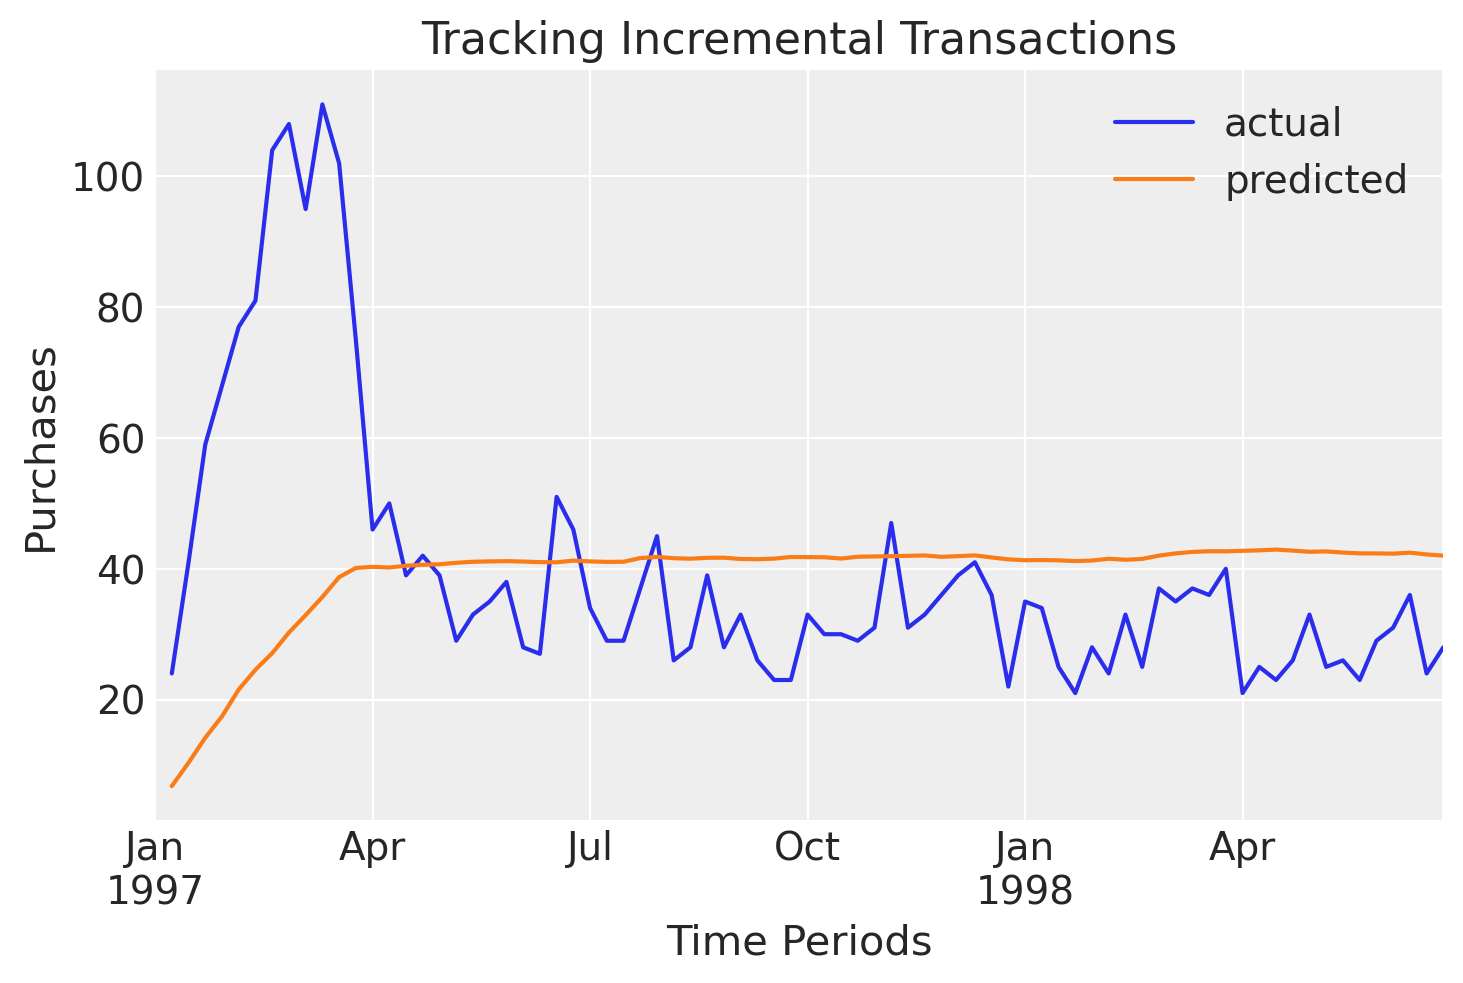

In [17]:
clv.plot_expected_purchases_over_time(
    model=bgm,
    purchase_history=raw_trans,
    datetime_col="date",
    customer_id_col="spent",
    datetime_format="%Y%m%d",
    time_unit="W",
    t=78,
    set_index_date=True,
    plot_cumulative=False,
);

There was a large sales bump in the first few months that is biasing model results and should be investigated. However, notice purchases flatline in the following months and the model is still able to capture this trend. Simply excluding data prior to Apr 1997 should improve performance considerably, but for pedagogical purposes we will continue with the tutorial.

### Visualizing Prediction Matrices

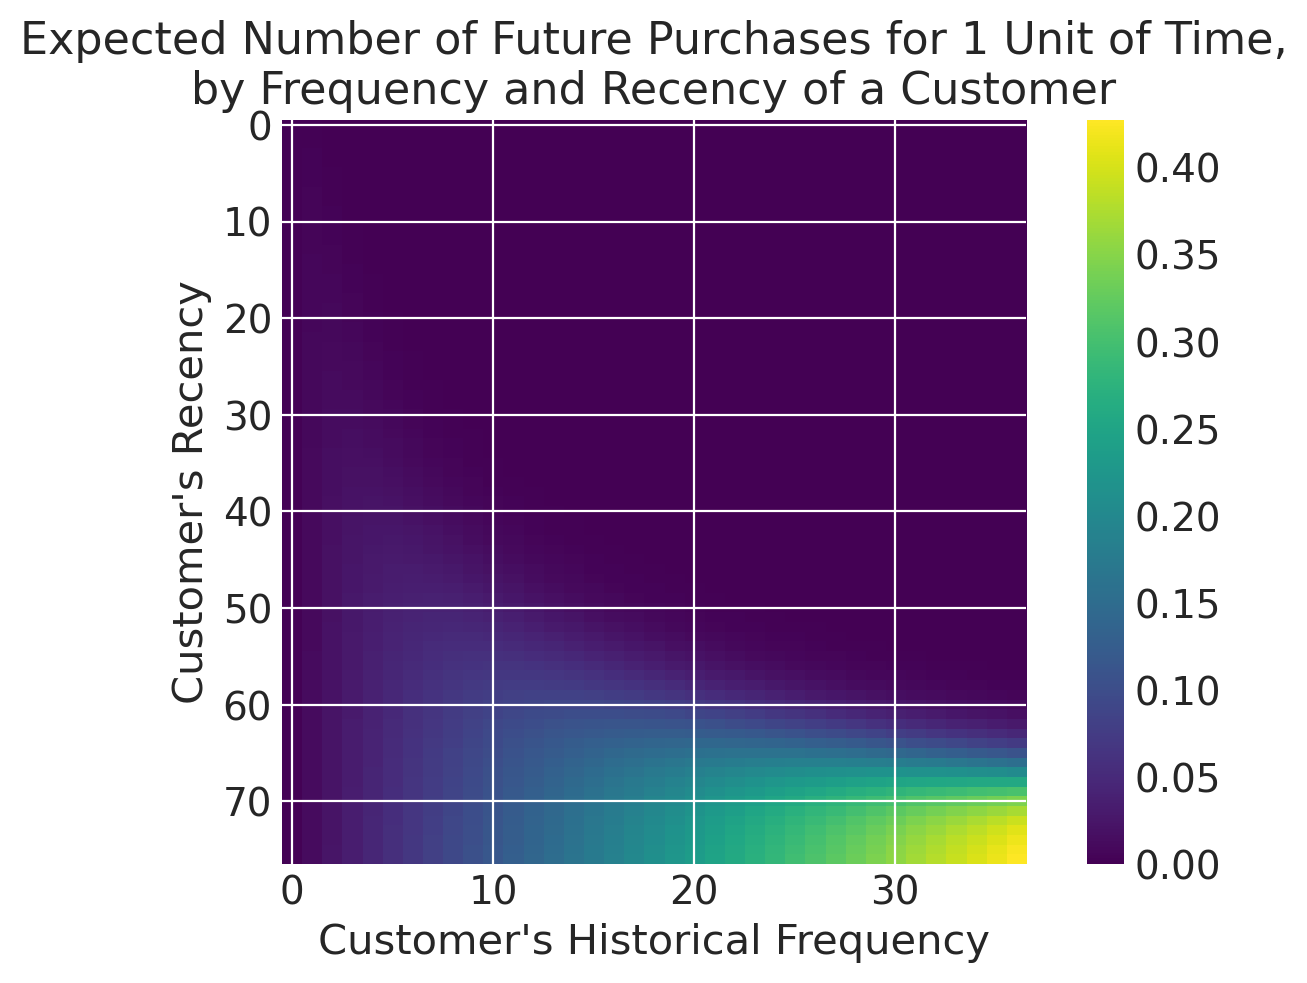

In [18]:
clv.plot_frequency_recency_matrix(bgm);

We can see our best customers have been active for over 60 weeks and have made over 20 purchases (bottom-right). Note the “tail” sweeping up towards the upper-left corner - these customers are infrequent and/or may not have purchased recently. What is the probability they are still active? 

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

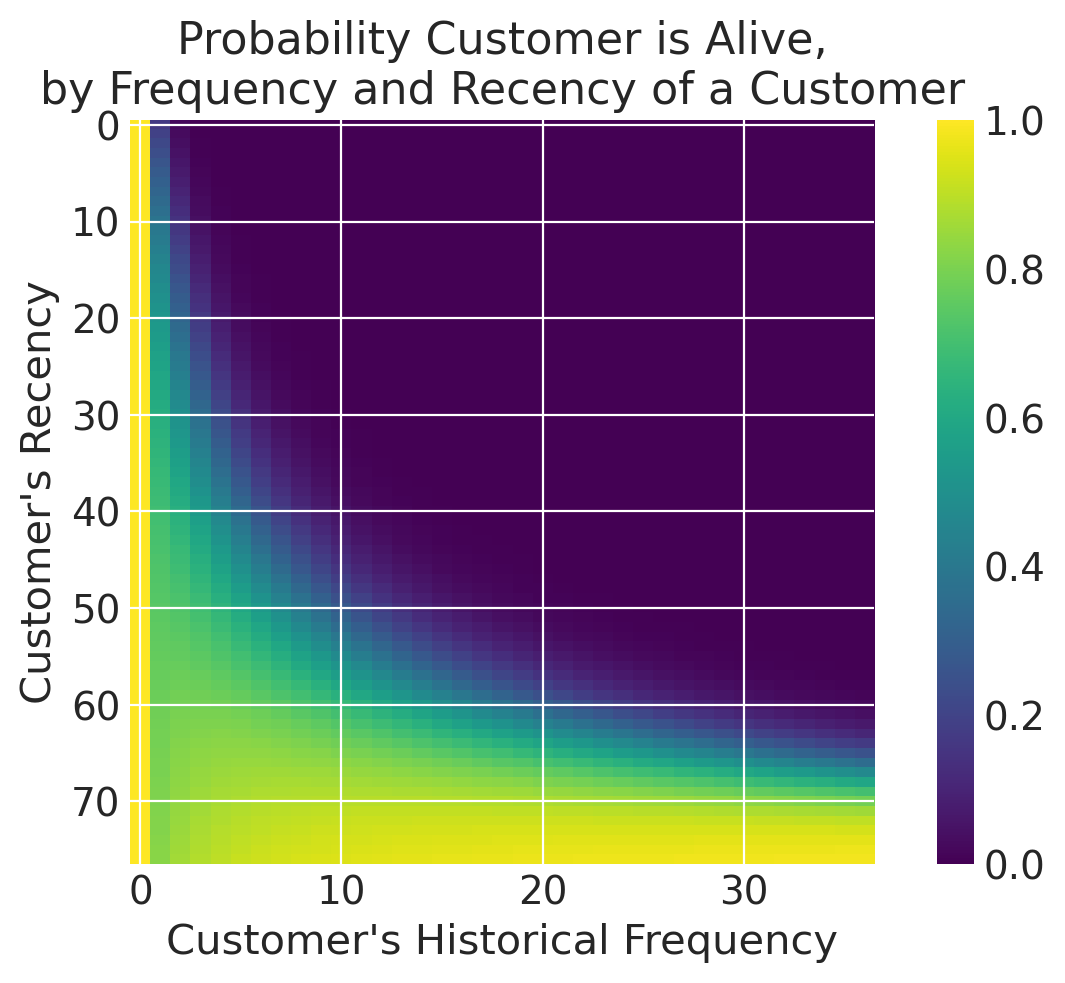

In [19]:
clv.plot_probability_alive_matrix(bgm)

Note that all non-repeat customers have an alive probability of 1, which is one of the quirks of `BetaGeoModel`. In many use cases this is still a valid assumption, but if non-repeat customers are a key focus in your use case, you may want to try `ParetoNBDModel` instead.  

Looking at the probability alive matrix, we can infer that customers who have made fewer purchases are less likely to return, and may be worth targeting for retention.

### Ranking customers from best to worst

Having fit the model, we can ask what is the expected number of purchases for our customers over the next 10 time periods. Let's look at the four more promising customers.

In [20]:
num_purchases = bgm.expected_purchases(future_t=10)

sdata = rfm_data.copy()
sdata["expected_purchases"] = num_purchases.mean(("chain", "draw")).values
sdata.sort_values(by="expected_purchases").tail(4)

,customer_id,frequency,recency,T,monetary_value,expected_purchases
812,813,30.0,72.0,74.0,35.654000,3.442359
1202,1203,32.0,71.0,72.0,47.172187,3.813059
156,157,36.0,74.0,77.0,30.603611,3.900408
1980,1981,35.0,66.0,68.0,46.748857,4.307184


We can also plot credibility intervals for the expected purchases:

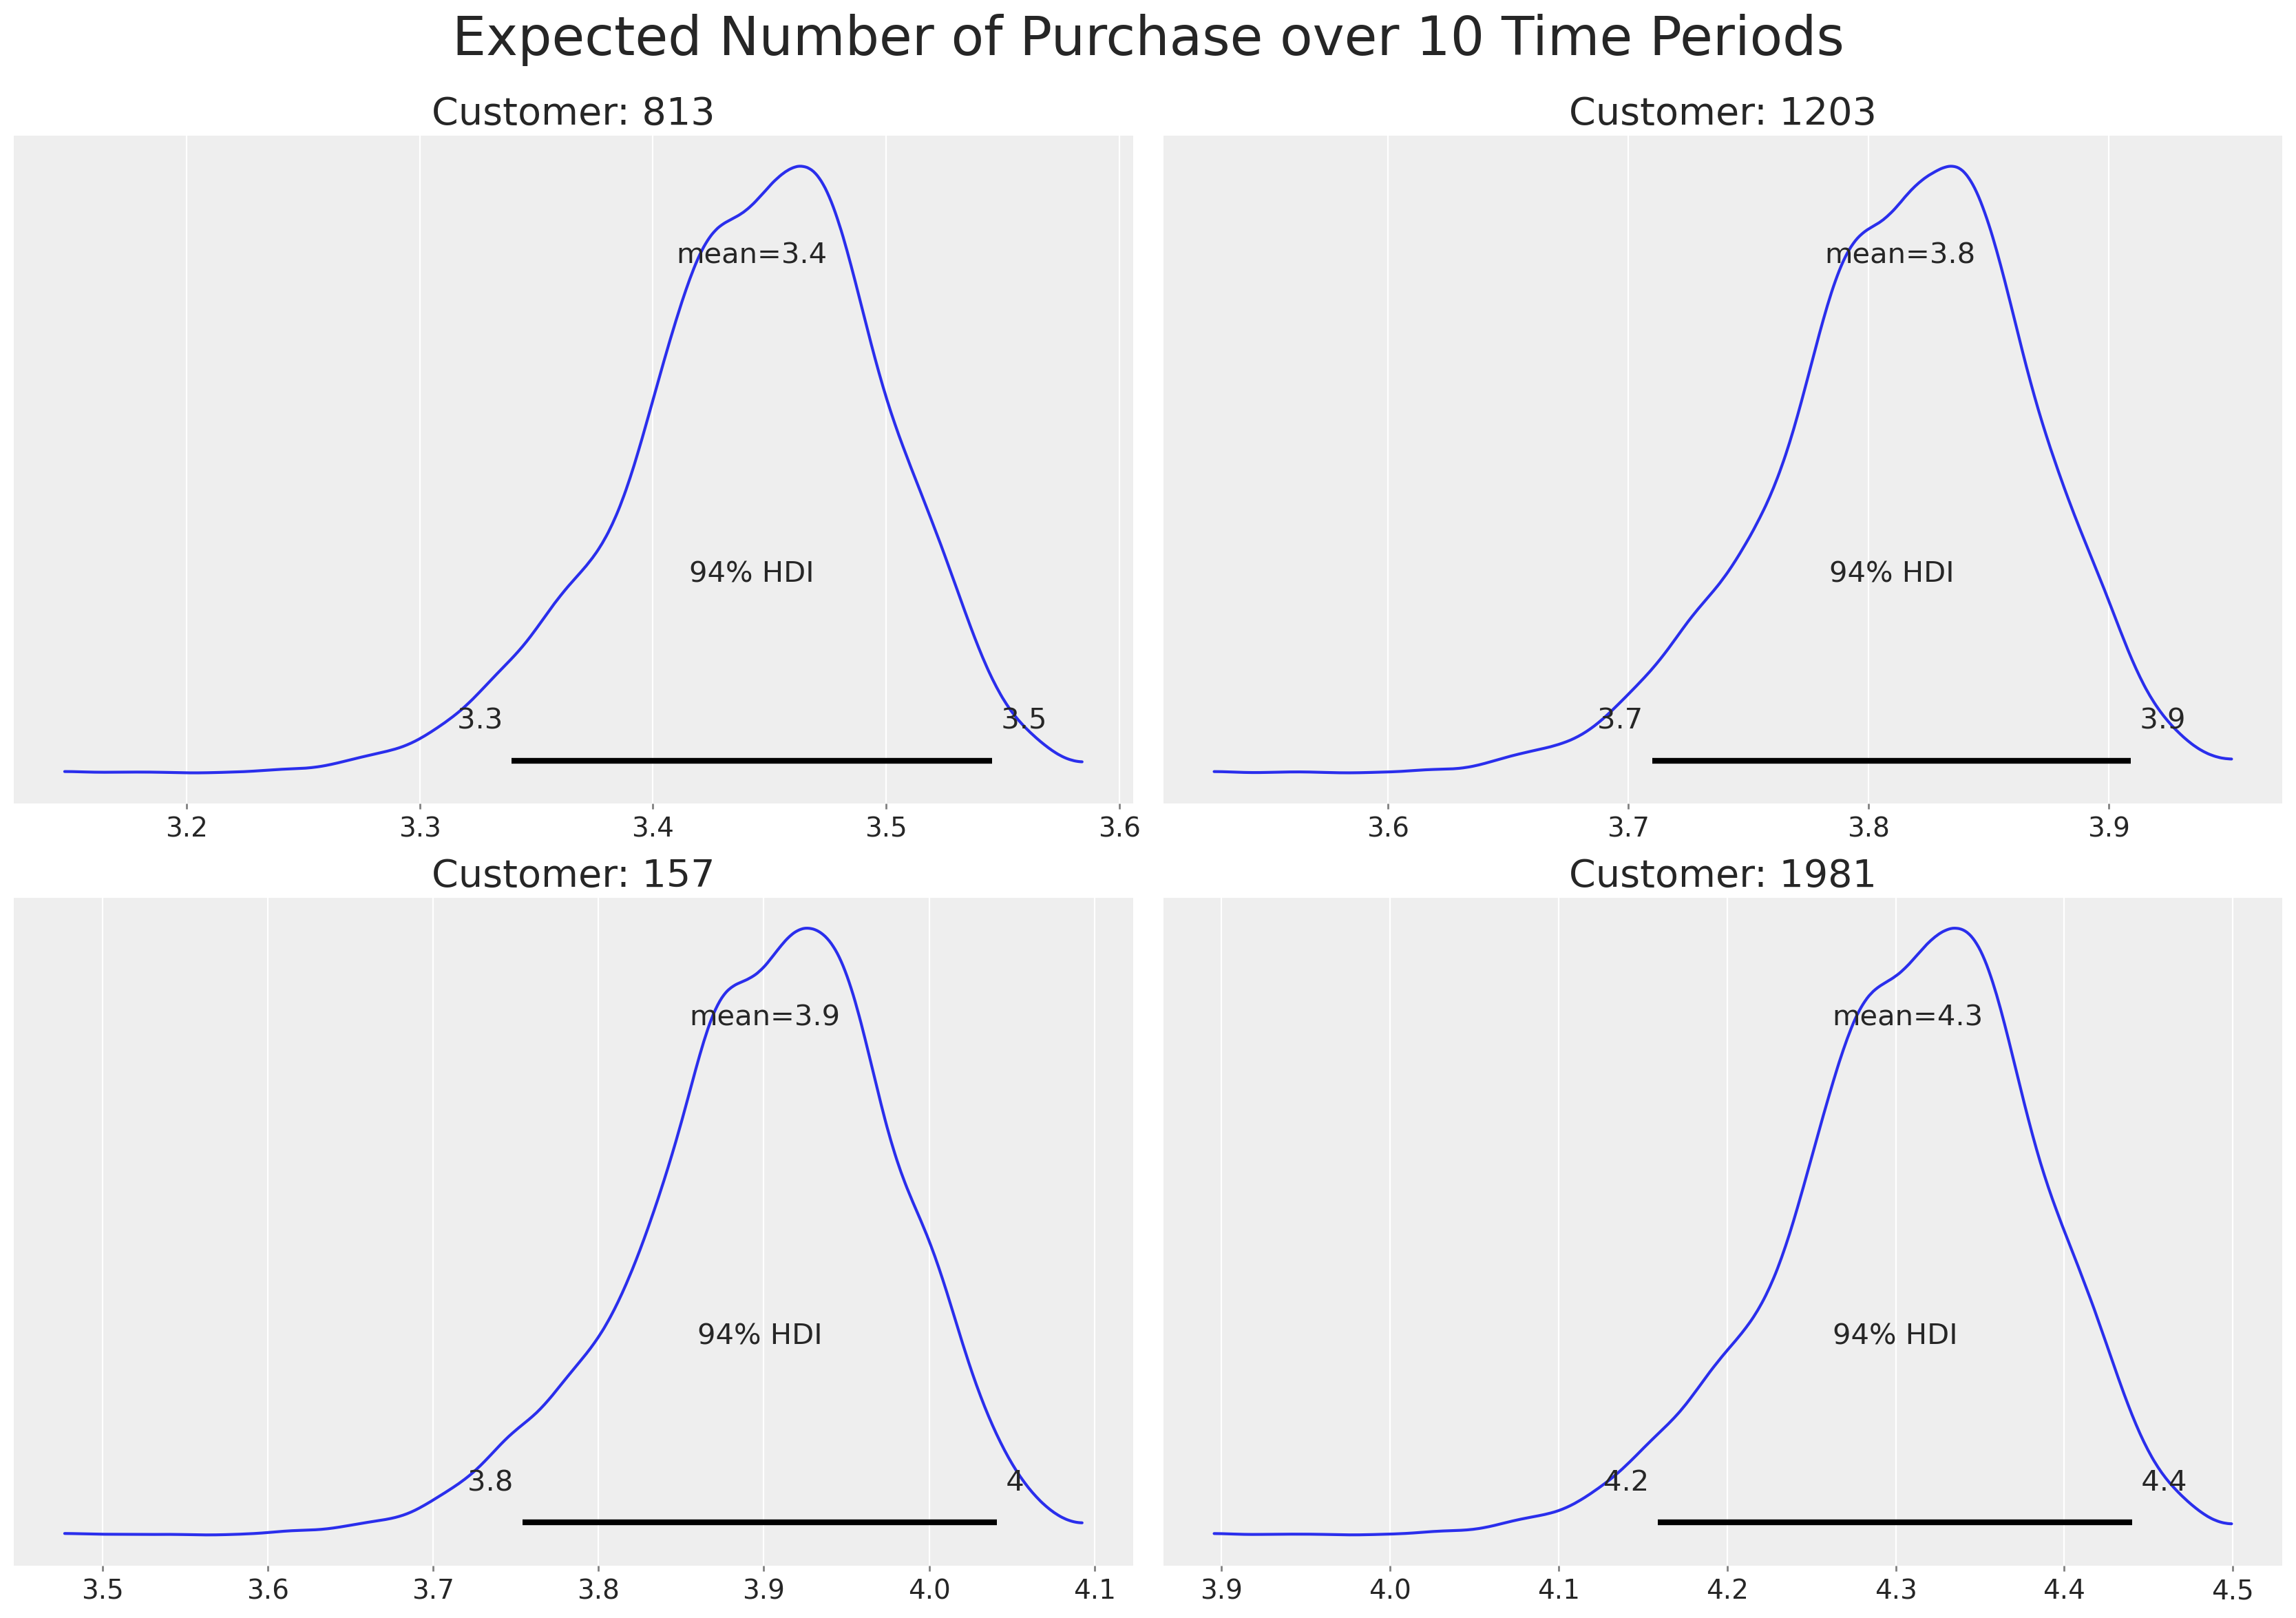

In [21]:
ids = [813, 1203, 157, 1981]
ax = az.plot_posterior(num_purchases.sel(customer_id=ids), grid=(2, 2))
for axi, id in zip(ax.ravel(), ids, strict=False):
    axi.set_title(f"Customer: {id}", size=20)
plt.suptitle("Expected Number of Purchase over 10 Time Periods", fontsize=28, y=1.05);

### Predicting purchase behavior of a new customer

We can use the fitted model to predict the number of purchases for a fresh new customer.

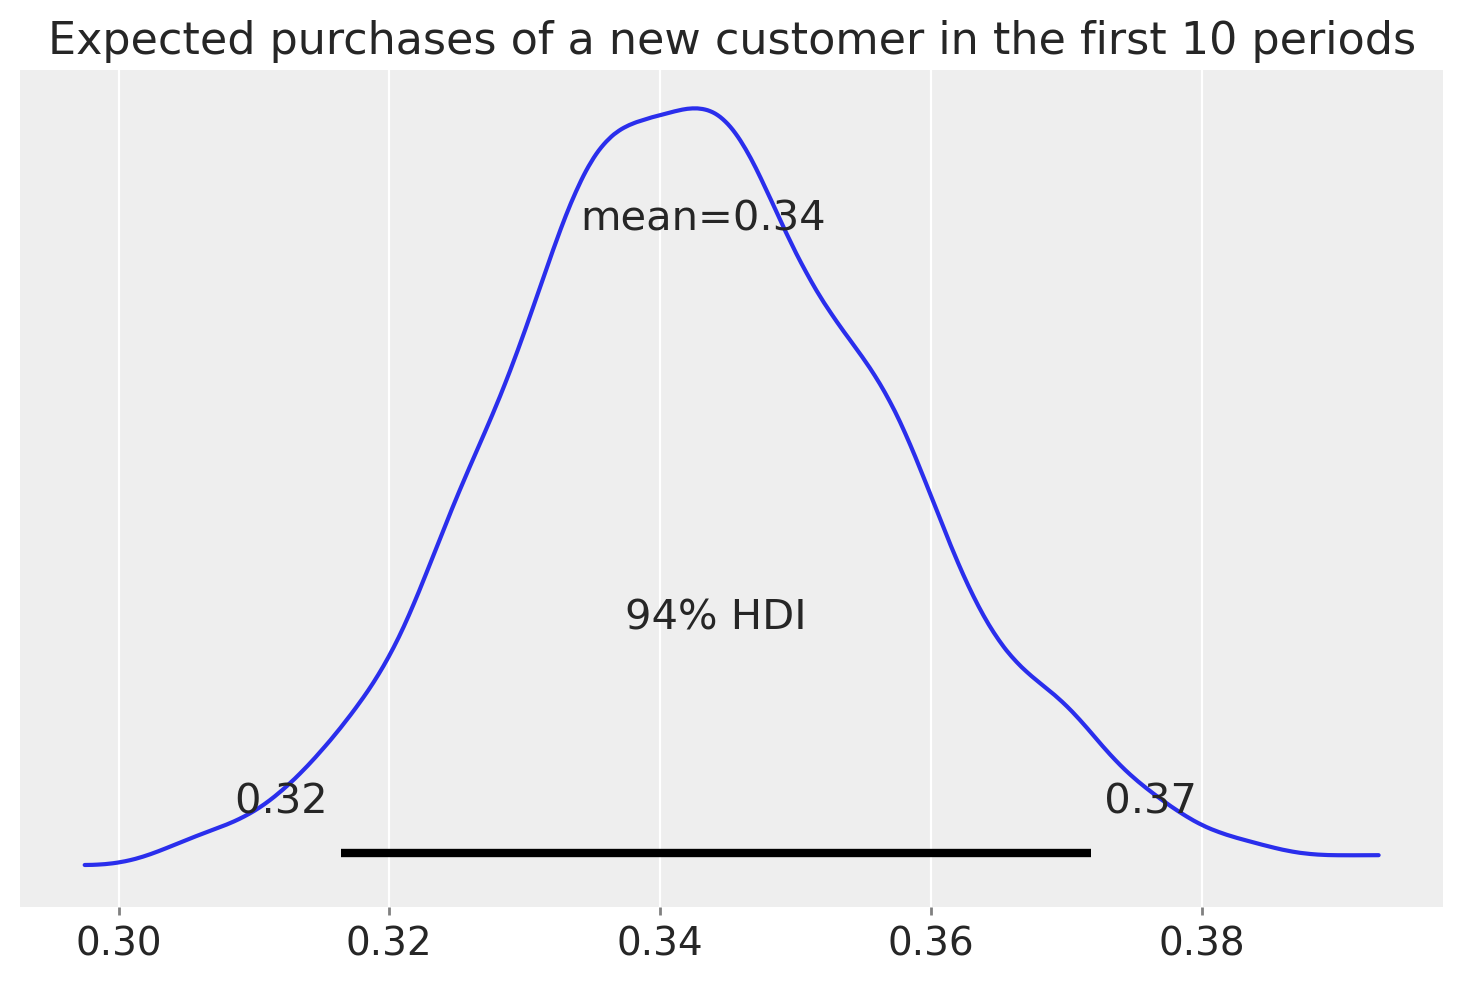

In [22]:
az.plot_posterior(bgm.expected_purchases_new_customer(t=10).sel(customer_id=1))
plt.title("Expected purchases of a new customer in the first 10 periods");

### Customer Probability Histories

Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model. 

Let look at active customer 1516 and assess the change in probability that the user will ever return if they do no other purchases in the next 9 time periods.

In [23]:
customer_1516 = rfm_data.loc[1515]
customer_1516

customer_id       1516.000000
frequency           27.000000
recency             67.000000
T                   70.000000
monetary_value      51.944074
Name: 1515, dtype: float64

In [24]:
customer_1516_history = pd.DataFrame(
    dict(
        customer_id=np.arange(10),
        frequency=np.full(10, customer_1516["frequency"], dtype="int"),
        recency=np.full(10, customer_1516["recency"]),
        T=(np.arange(0, 10) + customer_1516["recency"]).astype("int"),
    )
)
customer_1516_history

,customer_id,frequency,recency,T
0,0,27,67.0,67
1,1,27,67.0,68
2,2,27,67.0,69
3,3,27,67.0,70
4,4,27,67.0,71
5,5,27,67.0,72
6,6,27,67.0,73
7,7,27,67.0,74
8,8,27,67.0,75
9,9,27,67.0,76


In [25]:
p_alive = bgm.expected_probability_alive(data=customer_1516_history)

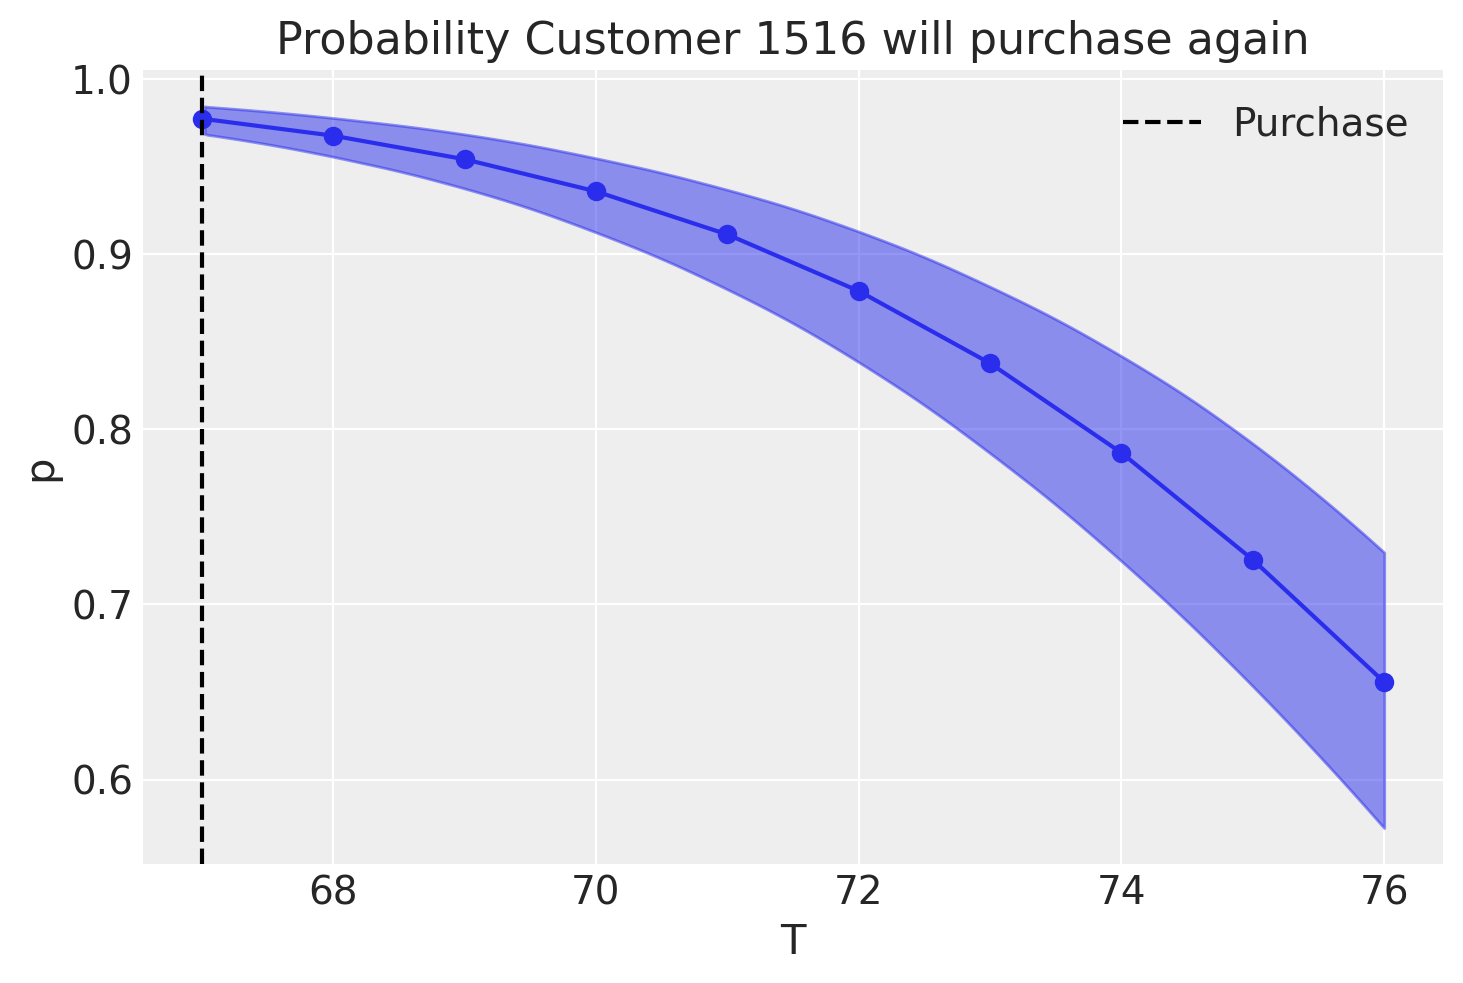

In [26]:
az.plot_hdi(customer_1516_history["T"], p_alive, color="C0")
plt.plot(customer_1516_history["T"], p_alive.mean(("draw", "chain")), marker="o")
plt.axvline(
    customer_1516_history["recency"].iloc[0], c="black", ls="--", label="Purchase"
)

plt.title("Probability Customer 1516 will purchase again")
plt.xlabel("T")
plt.ylabel("p")
plt.legend();

We can see that, if no purchases are being made in the next 9 weeks, the model has low confidence that the costumer will ever return. What if they had done one purchase in between?

In [27]:
customer_1516_history.loc[7:, "frequency"] += 1
customer_1516_history.loc[7:, "recency"] = customer_1516_history.loc[7, "T"] - 0.5
customer_1516_history

,customer_id,frequency,recency,T
0,0,27,67.0,67
1,1,27,67.0,68
2,2,27,67.0,69
3,3,27,67.0,70
4,4,27,67.0,71
5,5,27,67.0,72
6,6,27,67.0,73
7,7,28,73.5,74
8,8,28,73.5,75
9,9,28,73.5,76


In [28]:
p_alive = bgm.expected_probability_alive(data=customer_1516_history)

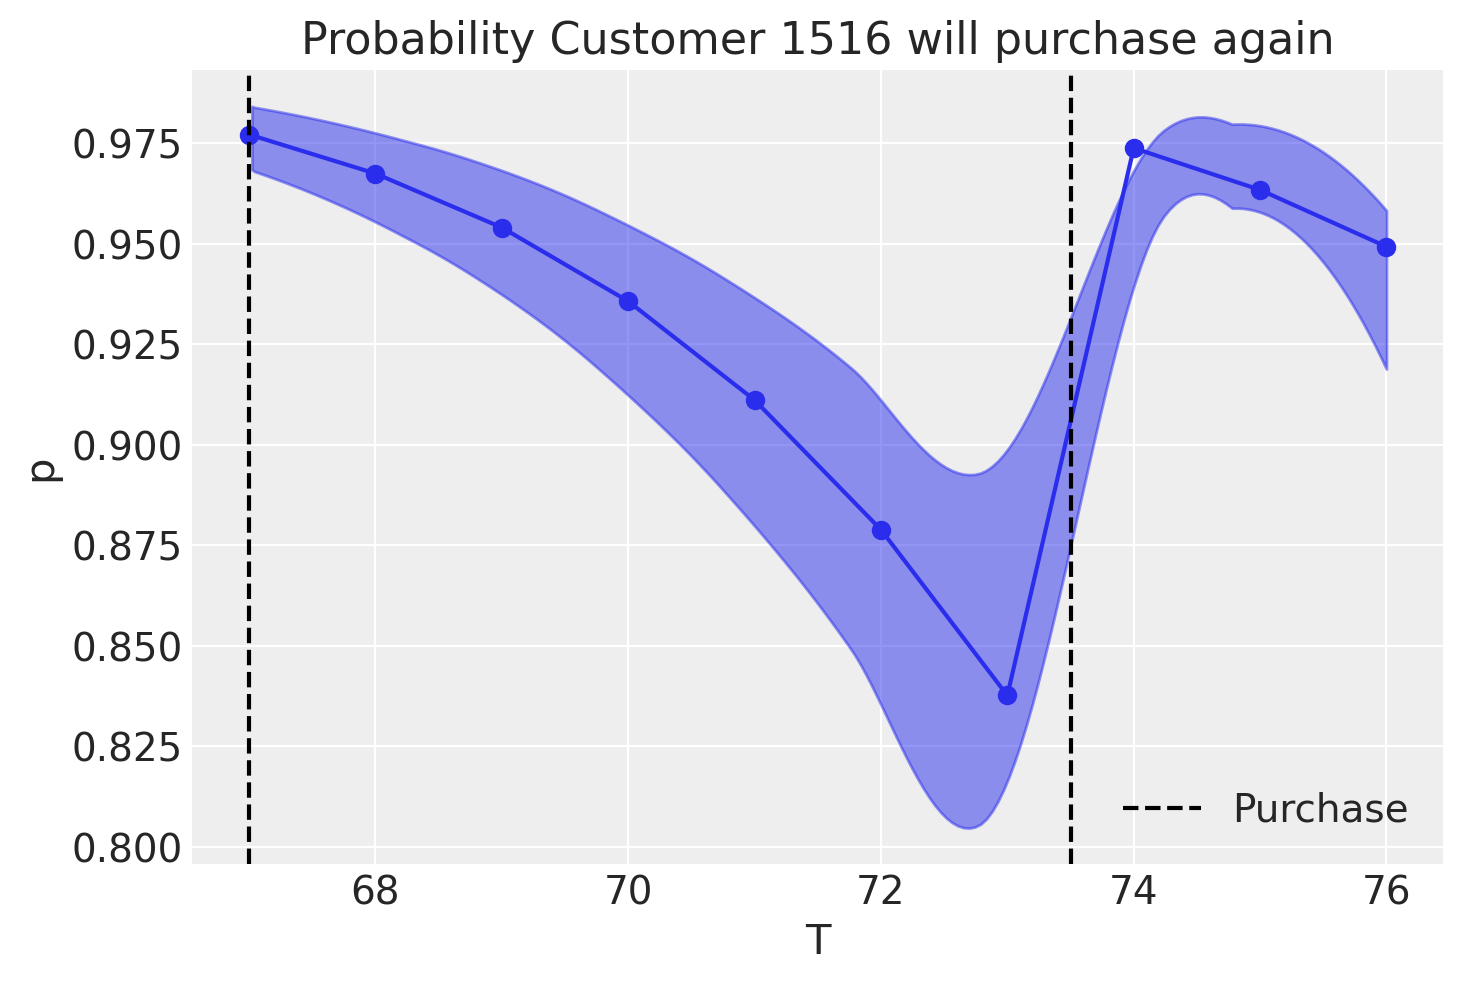

In [29]:
az.plot_hdi(customer_1516_history["T"], p_alive, color="C0")
plt.plot(customer_1516_history["T"], p_alive.mean(("draw", "chain")), marker="o")
plt.axvline(
    customer_1516_history["recency"].iloc[0], c="black", ls="--", label="Purchase"
)
plt.axvline(customer_1516_history["recency"].iloc[-1], c="black", ls="--")

plt.title("Probability Customer 1516 will purchase again")
plt.xlabel("T")
plt.ylabel("p")
plt.legend();

From the plot above, say that customer 1516 makes a purchase at week 73.5, just over 6 weeks after they have made their last recorded purchase. We can see that the probability of the customer returning quickly goes back up!

## Estimating Customer Lifetime Value Using the Gamma-Gamma Model

Until now we’ve focused mainly on transaction frequencies and probabilities, but to estimate economic value we can use the Gamma-Gamma model.

The Gamma-Gamma model assumes at least 1 repeat transaction has been observed per customer. As such we filter out those with zero repeat purchases.

In [30]:
nonzero_data = rfm_data.query("frequency>0")
nonzero_data

,customer_id,frequency,recency,T,monetary_value
0,1,3.0,49.0,78.0,23.723333
1,2,1.0,2.0,78.0,11.770000
5,6,14.0,76.0,78.0,76.503571
6,7,1.0,5.0,78.0,11.770000
7,8,1.0,61.0,78.0,26.760000
...,...,...,...,...,...
2351,2352,1.0,47.0,66.0,14.490000
2352,2353,2.0,53.0,66.0,19.775000
2353,2354,5.0,24.0,66.0,44.928000
2354,2355,1.0,44.0,66.0,24.600000


If computing the monetary value from your own data, note that it is the *mean* of a given customer’s value, *not* the sum. `monetary_value` can be used to represent profit, or revenue, or any value as long as it is consistently calculated for each customer.

The Gamma-Gamma model relies upon the important assumption there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation is less than 0.3:

In [31]:
nonzero_data[["monetary_value", "frequency"]].corr()

,monetary_value,frequency
monetary_value,1.000000,0.052819
frequency,0.052819,1.000000


Transaction frequencies and monetary values are uncorrelated; we can now fit our Gamma-Gamma model to predict average spend and expected lifetime values of our customers

The Gamma-Gamma model takes in a 'data' parameter, a pandas DataFrame with 3 columns representing Customer ID, average spend of repeat purchases, and number of repeat purchase for that customer. As with the BG/NBD model, these parameters are given HalfFlat priors which can be too diffuse for small datasets. For this example, we will use the default priors, but other priors can be specified just like with the BG/NBD example above.

In [32]:
gg = clv.GammaGammaModel(data=nonzero_data)
gg.build_model()
gg

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

By default, `fit` generates full Bayesian posteriors via [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) sampling. For extremely large datasets where the full posterior is not needed and/dor MCMC is too slow, the [maximum a posteriori](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) `method` can be used to estimate point estimates for model parameters.

In [33]:
gg.fit(method="map")

Output()

Inference data with groups:
	> posterior
	> fit_data

In [34]:
gg.fit_summary()

p     4.785
q     3.882
v    22.653
Name: value, dtype: float64

However, MCMC sampling is recommended to illustrate uncertainty in parameter estimates and create credibility intervals around predictions.

In [35]:
gg.fit();

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [36]:
gg.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,4.842,0.769,3.440,6.235,0.024,0.019,1000.0,1027.0,1.0
q,3.923,0.282,3.445,4.512,0.009,0.006,1038.0,1247.0,1.0
v,23.449,5.238,13.562,32.856,0.172,0.127,932.0,1007.0,1.0


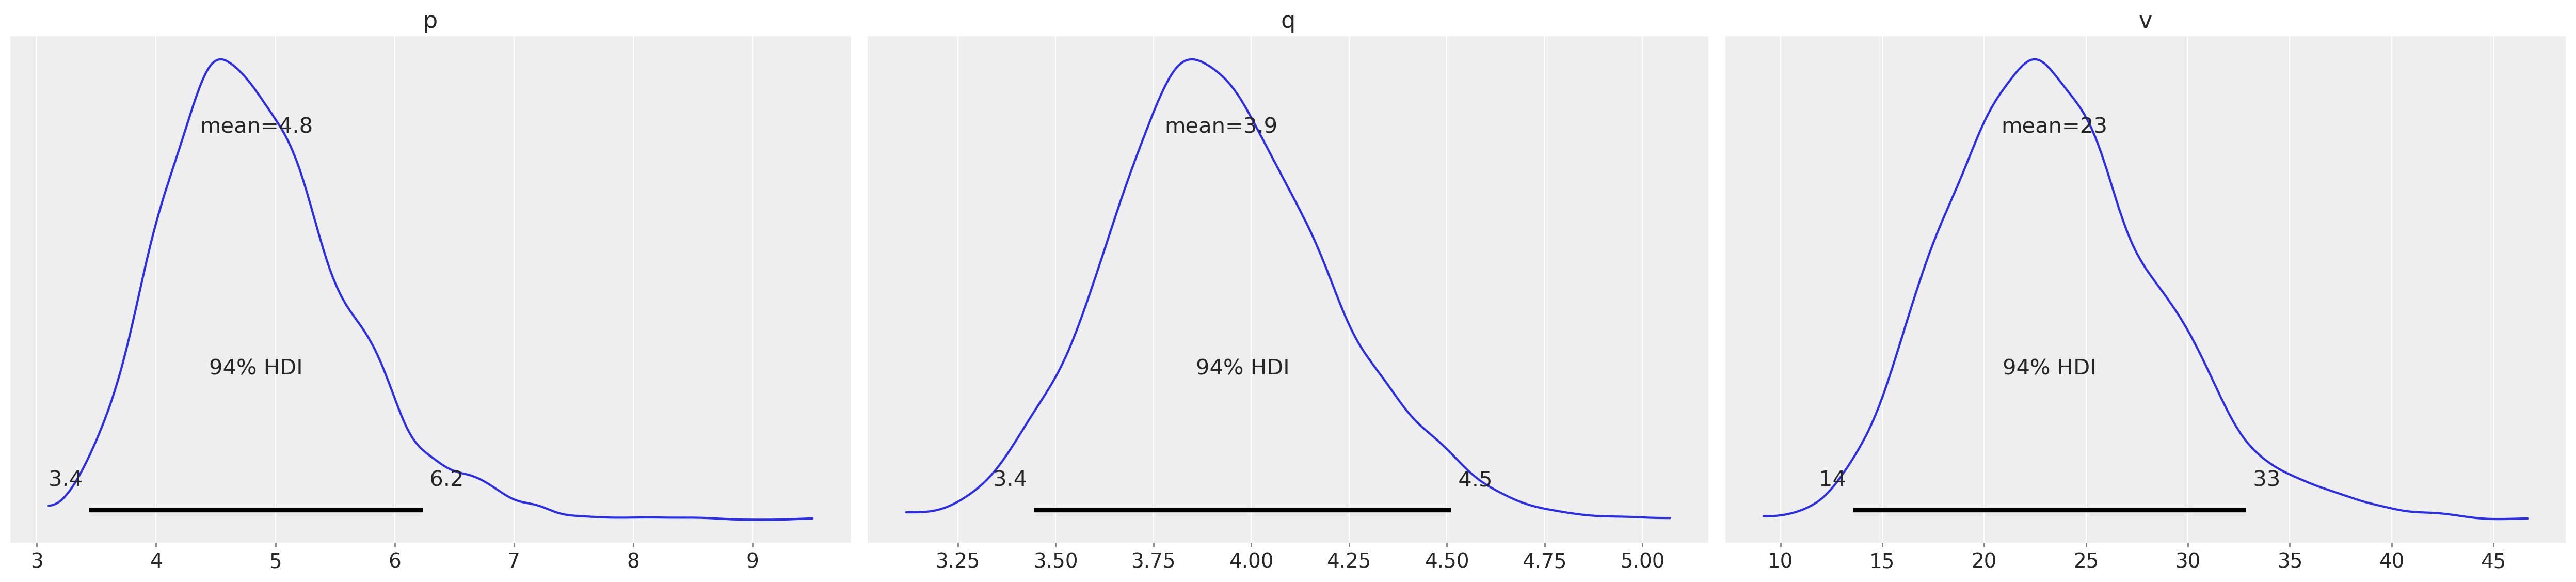

In [37]:
az.plot_posterior(gg.fit_result);

### Predicting spend value of customers

Having fit our model, we can now use it to predict the conditional, expected average lifetime value of our customers, including those with zero repeat purchases.

In [38]:
expected_spend = gg.expected_customer_spend(data=rfm_data)

In [39]:
az.summary(expected_spend.isel(customer_id=range(10)), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[1],26.094,0.439,25.294,26.918
x[2],21.575,1.341,19.081,24.096
x[3],37.623,0.892,35.951,39.275
x[4],37.623,0.892,35.951,39.275
x[5],37.623,0.892,35.951,39.275
x[6],74.847,0.368,74.200,75.543
x[7],21.575,1.341,19.081,24.096
x[8],30.875,0.607,29.762,32.031
x[9],36.429,0.151,36.151,36.722
x[10],37.623,0.892,35.951,39.275


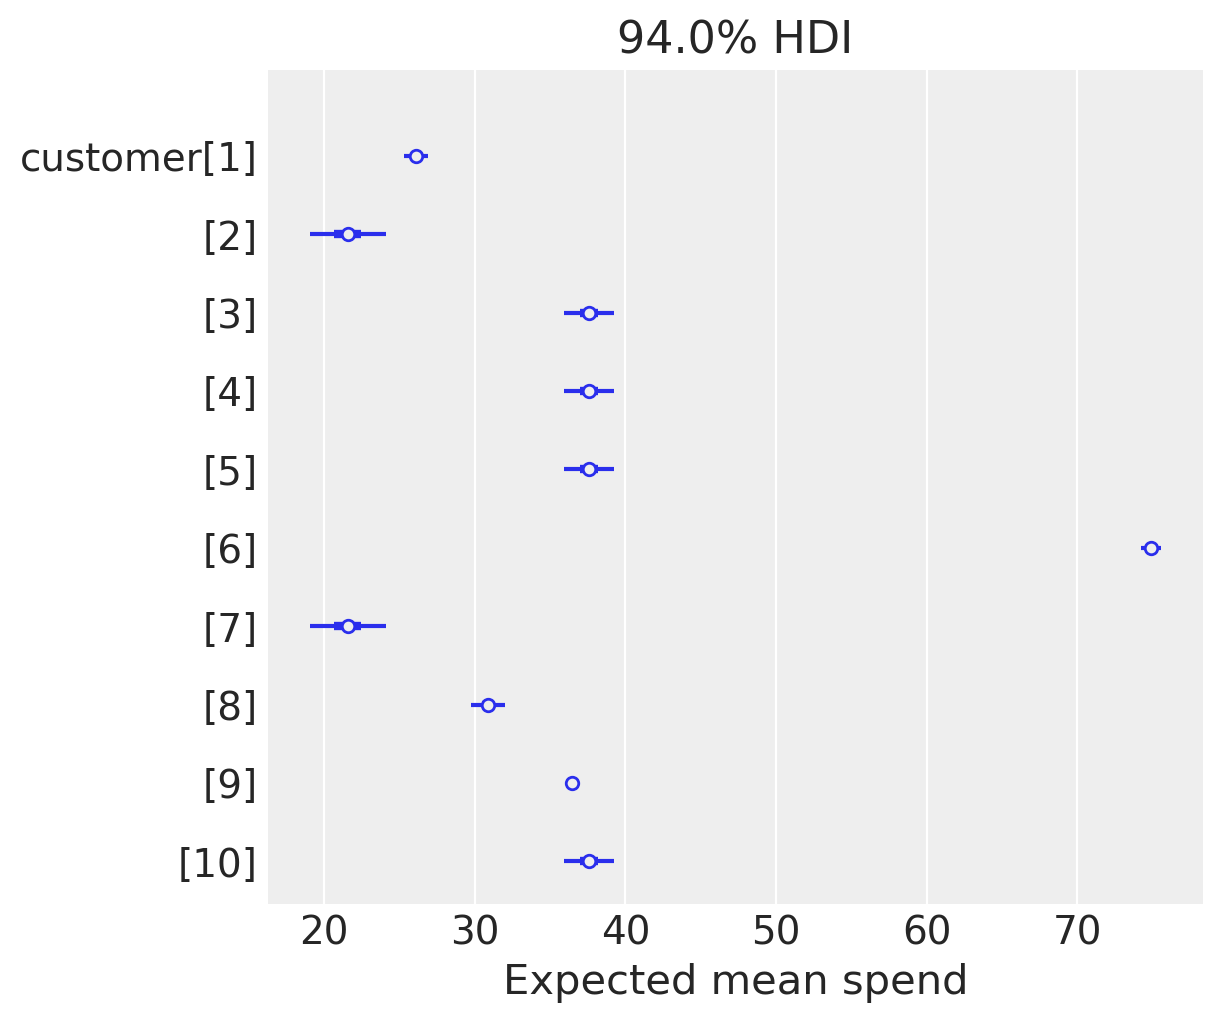

In [40]:
labeller = MapLabeller(var_name_map={"x": "customer"})
az.plot_forest(
    expected_spend.isel(customer_id=(range(10))), combined=True, labeller=labeller
)
plt.xlabel("Expected mean spend");

We can also look at the average expected mean spend across all customers

In [41]:
az.summary(expected_spend.mean("customer_id"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,38.004,0.562,36.938,39.032


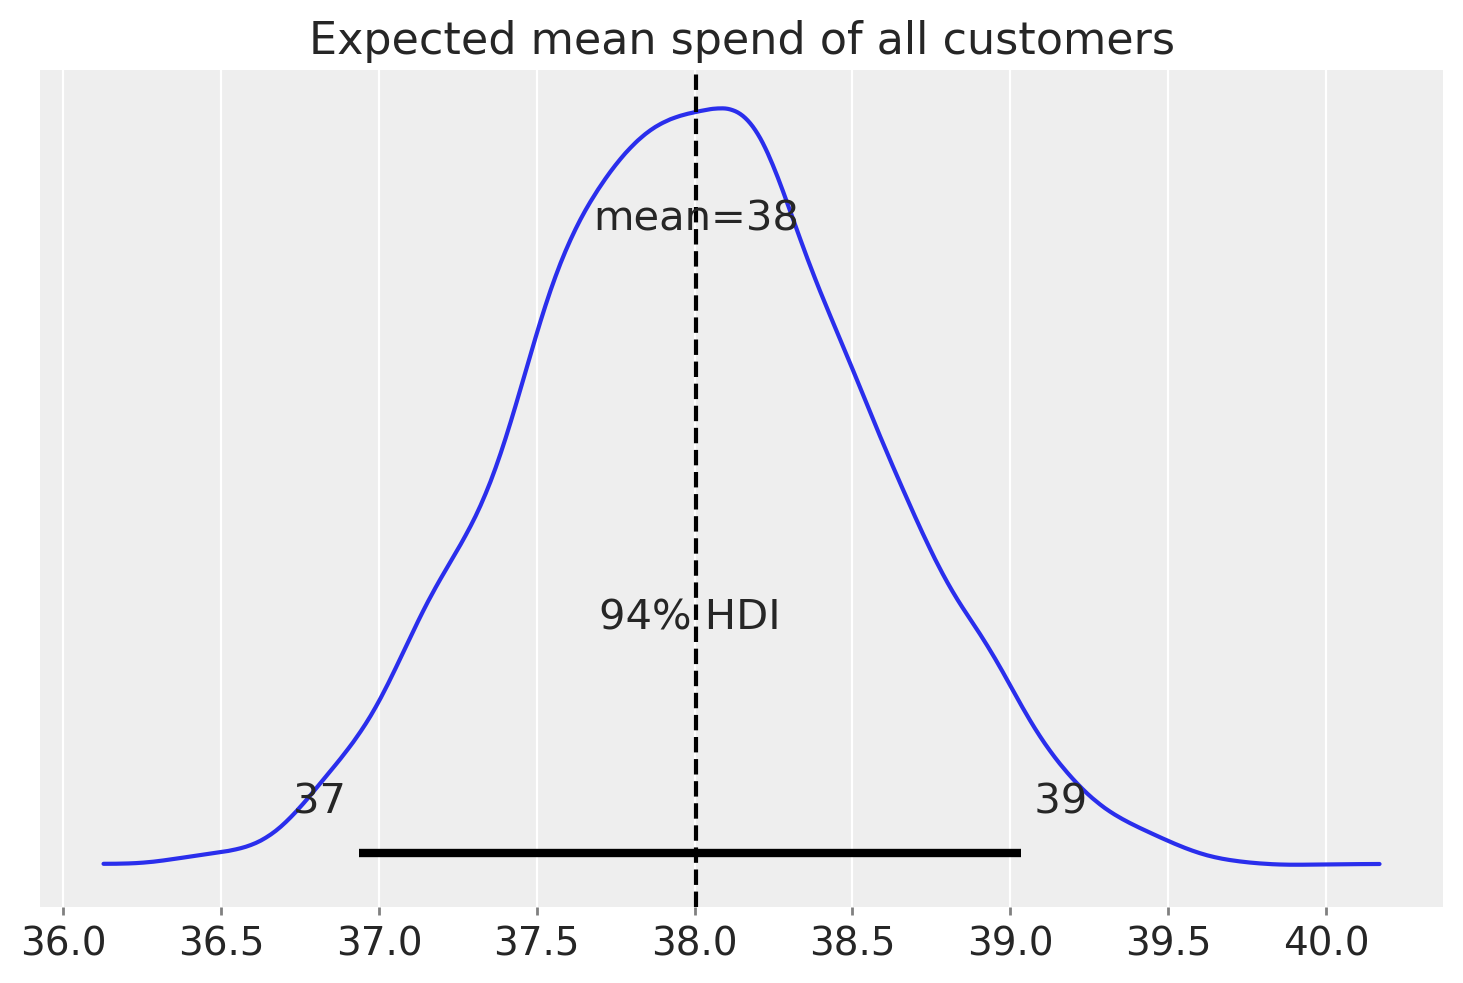

In [42]:
az.plot_posterior(expected_spend.mean("customer_id"))
plt.axvline(expected_spend.mean(), color="k", ls="--")
plt.title("Expected mean spend of all customers");

### Predicting spend value of a new customer

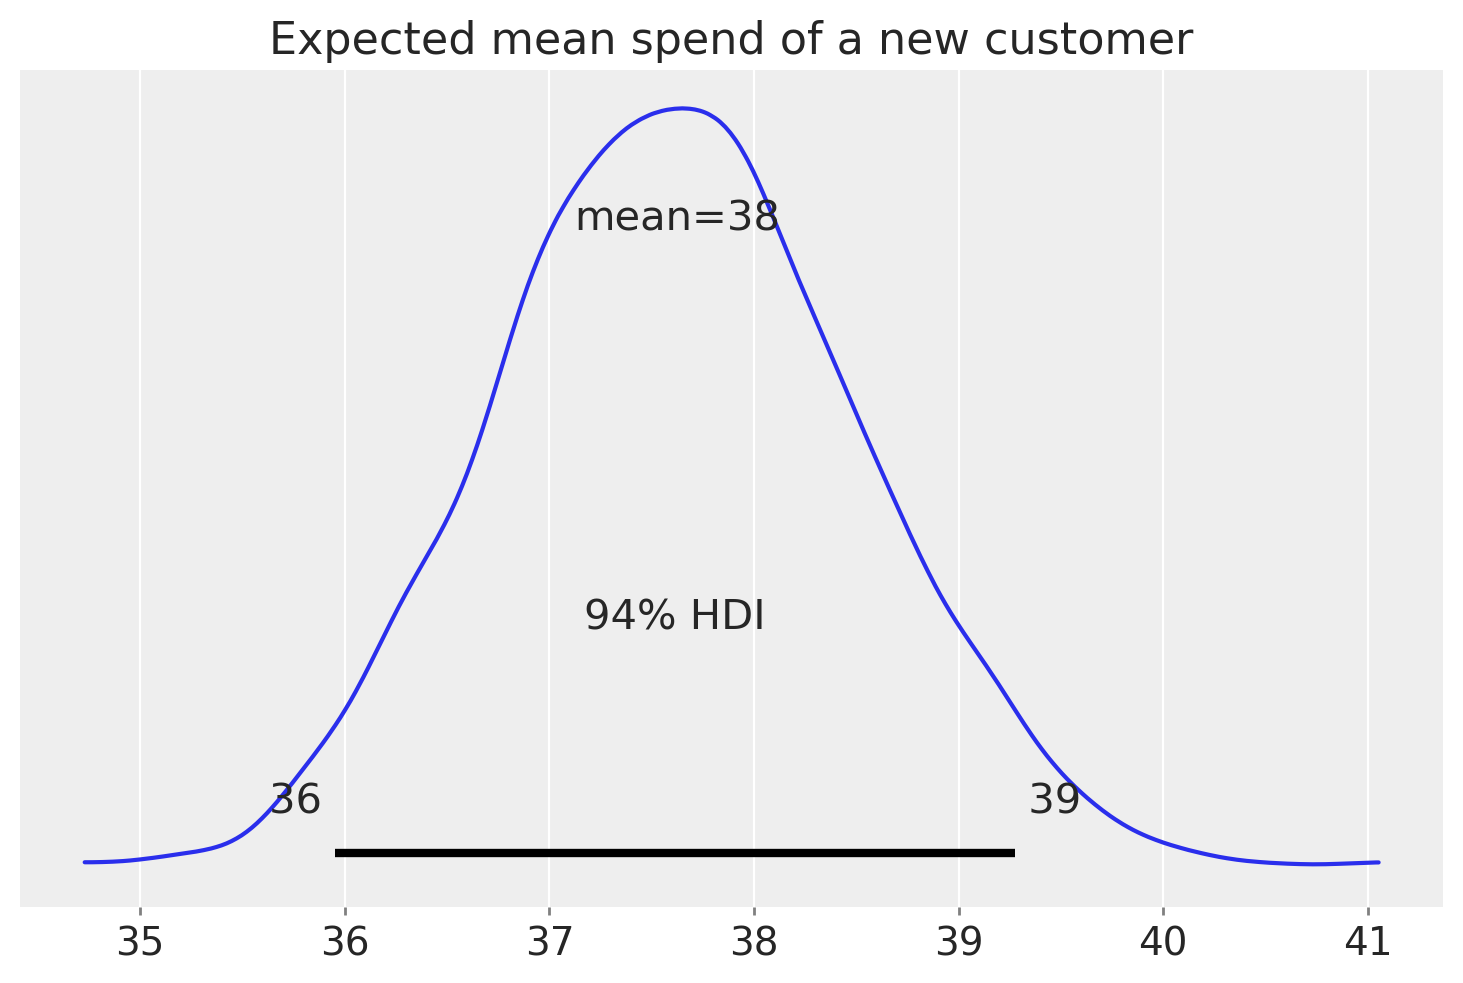

In [43]:
az.plot_posterior(gg.expected_new_customer_spend())
plt.title("Expected mean spend of a new customer");

### Estimating CLV

Finally, we can combine the GG with the BG/NBD model to obtain an estimate of the customer lifetime value. This relies on the [discounted cash flow](https://en.wikipedia.org/wiki/Discounted_cash_flow) model, adjusting for cost of capital.

If computational issues are encountered, use the `thin_fit_result` method prior to estimating CLV.

In [44]:
bgm.thin_fit_result(keep_every=2)

BG/NBD
            alpha ~ HalfNormal(0, 10)
                a ~ HalfNormal(0, 10)
                b ~ HalfNormal(0, 10)
                r ~ HalfNormal(0, 10)
recency_frequency ~ BetaGeoNBD(a, b, r, alpha, <constant>)

In [45]:
clv_estimate = gg.expected_customer_lifetime_value(
    transaction_model=bgm,
    data=rfm_data,
    future_t=12,  # months
    discount_rate=0.01,  # monthly discount rate ~ 12.7% annually
    time_unit="W",  # original data is in weeks
)

In [46]:
az.summary(clv_estimate.isel(customer_id=range(10)), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[1],29.215,1.017,27.311,31.128
x[2],3.092,0.302,2.518,3.628
x[3],5.621,0.221,5.195,6.032
x[4],5.621,0.221,5.195,6.032
x[5],5.621,0.221,5.195,6.032
x[6],501.318,16.543,469.815,531.667
x[7],4.066,0.343,3.436,4.697
x[8],16.192,0.426,15.359,16.946
x[9],46.868,1.276,44.505,49.313
x[10],5.621,0.221,5.195,6.032


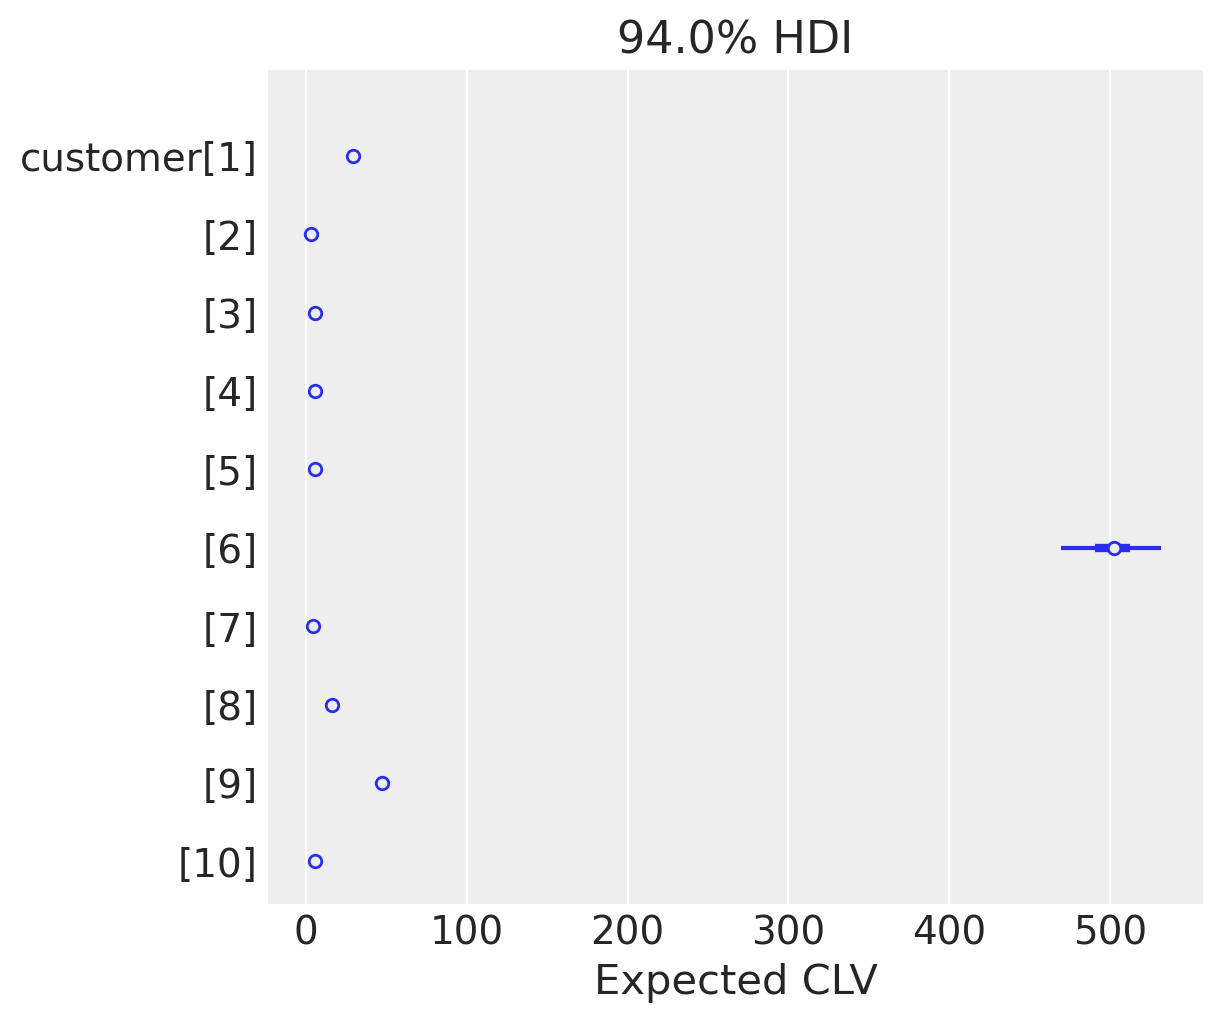

In [47]:
az.plot_forest(
    clv_estimate.isel(customer_id=range(10)), combined=True, labeller=labeller
)
plt.xlabel("Expected CLV");

According to our models, customer[6] has a much higher expected CLV. There is also a large variability in this estimate that arises solely from uncertainty in the parameters of the BG/NBD and GG models. 

In general, these models tend to induce a strong correlation between expected CLV and uncertainty. This modelling of uncertainty can be very useful when making marketing decisions.

In [49]:
# %load_ext watermark
# %watermark -n -u -v -iv -w -p pymc,pytensor